In [1]:
import glob, os, sys
import uproot, ROOT
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, roc_auc_score, auc
sys.path.append("..")
from utils.utils import *

Welcome to JupyROOT 6.30/04


In [2]:
# def signal_cut(df_chunk):
#     cut1 = (df_chunk['IsTruthHadronic']==1)
#     cut2 = (df_chunk['n_subjets'] >=2)
#     cut3 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
#     cut4 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
#     return (cut1 & cut2 & cut3 & cut4)
    
# def bkg_cut(df_chunk):
#     cut1 = (df_chunk['n_subjets'] >=2)
#     cut2 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
#     cut3 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
#     return (cut1 & cut2 & cut3)

# def h52panda(filelist, xs, cut, bkg=0):
#     combined = pd.DataFrame()
#     chunk_size = 10000000  # Adjust this size to suit your system's memory
#     pt_bins = np.linspace(200000, 1000000, 41)

#     dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
#                 "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
#                 "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
#                 "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
#                 "d0_leadtrack_lead", "d0_leadtrack_subl",
#                 "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
#                 "event_weight", "bdt_score", "bdt_score_new", "average_mu", "eta"]

#     for index in range(len(filelist)):
#         file_path = filelist[index]
    
#         # Process the file in chunks
#         with h5py.File(file_path, 'r') as h5_file:
#             # Determine the total length of the datasets
#             total_length = h5_file[dataset_keys[0]].shape[0]
#             print(f'{filelist[index]}: {total_length}')
#             print(len(h5_file["d0_leadtrack_subl"]), len(h5_file["lead_subjet_pt"]), len(h5_file["trackPt"]))
#             # Read and process each chunk
#             for chunk_start in range(0, total_length, chunk_size):
#                 chunk_end = chunk_start + chunk_size

#                 # Use slicing to read a chunk from each dataset in the HDF5 file
#                 data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

#                 # Convert the dictionary to a pandas DataFrame
#                 df_chunk = pd.DataFrame(data)

#                 # Apply Cut
#                 filtered_chunk = df_chunk[cut(df_chunk)]
#                 filtered_chunk = filtered_chunk.copy()
#                 filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index]) 

#                 combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
#     combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])
#     combined['label'] = bkg
#     combined['weight'] = combined['event_weight'] * combined['pT_weight']

#     return combined

# path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"

# bkg_xs = [364701, 364702, 364703, 364704, 364705, 364706, 364707, 364708, 364709, 364710, 364711, 364712]
# signal_xs = [425108, 425100, 425101, 425102, 425103, 425104, 425105, 425106, 425107, 425200]
# # gamma_xs = [425200]

# # File Location. order maatch XS. 
# bkg_filelist = []
# for index in range(12):
#     bkg_filelist.append(path+f"jz_w_newbdt/dijet_flattened_jz{index}.h5")
# print(bkg_filelist)

# # signal_filelist = [path+"signal_w_newbdt/graviton_flattened_M1000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M1500.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M1750.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M2000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M2250.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M2500.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M3000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M4000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M5000.h5",
# #                 path+"signal_w_newbdt/gamma_flattened_0.h5"]

# # combined_signal = h52panda(signal_filelist, signal_xs, signal_cut, 1)
# combined_bkg = h52panda(bkg_filelist, mc23_jz_xs, bkg_cut, 0)

# comb_vh_signal = h52panda([path+"ntuple_flattened_VHtautau.h5"], [802168], signal_cut, 1)

In [6]:
def signal_cut(df_chunk):
    cut1 = (df_chunk['IsTruthHadronic']==1)
    cut2 = (df_chunk['n_subjets'] >=2)
    cut3 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut4 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    return (cut1 & cut2 & cut4)
    
def bkg_cut(df_chunk):
    cut1 = (df_chunk['n_subjets'] >=2)
    cut2 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut3 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    # cut4 = (df_chunk['event_weight'] < 1000)
    return (cut1 & cut3)

def h52panda(filelist, xs, cut, bkg=0):
    combined = pd.DataFrame()
    chunk_size = 10000000  # Adjust this size to suit your system's memory
    pt_bins = np.linspace(200000, 1000000, 41)

    dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
                "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
                "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
                "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
                "d0_leadtrack_lead", "d0_leadtrack_subl",
                "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
                "event_weight", "bdt_score", "bdt_score_new", "average_mu", "eta", "lead_subjet_pt", "sublead_subjet_pt"]
    track_data_keys = ['charge']

    for index in range(len(filelist)):
        file_path = filelist[index]
    
        # Process the file in chunks
        with h5py.File(file_path, 'r') as h5_file:
            # Determine the total length of the datasets
            total_length = h5_file[dataset_keys[0]].shape[0]
            print(f'{filelist[index]}: {total_length}')
            print(len(h5_file["d0_leadtrack_subl"]), len(h5_file["lead_subjet_pt"]), len(h5_file["trackPt"]))
            # Read and process each chunk
            for chunk_start in range(0, total_length, chunk_size):
                chunk_end = chunk_start + chunk_size

                # Use slicing to read a chunk from each dataset in the HDF5 file
                data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

                # Convert the dictionary to a pandas DataFrame
                df_chunk = pd.DataFrame(data)

                filtered_chunk = df_chunk

                filtered_chunk = filtered_chunk.copy()
                print("XS: ", getXS(xs[index]) )
                filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index]) 

                # Apply Cut
                filtered_chunk = filtered_chunk[cut(filtered_chunk)]

                combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
    combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])
    combined['label'] = bkg
    combined['weight'] = combined['event_weight'] * combined['pT_weight']

    return combined

path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"

mc23_jz_xs = [801165, 801166, 801167, 801168, 801169, 801170, 801171, 801172, 801173, 801174]
# mc23_jz_xs = [801167, 801168, 801169, 801170, 801171, 801172, 801173, 801174]

# File Location. order maatch XS. 
bkg_filelist = []
for index in range(10):
    bkg_filelist.append(path+f"ntuple_flattened_v2_jz{index}.h5")

print(bkg_filelist)
combined_bkg = h52panda(bkg_filelist, mc23_jz_xs, bkg_cut, 0)

comb_vh_signal = h52panda([path+"ntuple_flattened_VHtautau.h5"], [802168], signal_cut, 1)

print(len(combined_bkg), len(comb_vh_signal))

['/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz0.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz1.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz2.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz3.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz4.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz5.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz6.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz7.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz8.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz9.h5']
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_

In [13]:
# Load the evaluated probabilities
path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"
filename = "/global/u2/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/PET_tau_8_local_layer_scale_token_baseline_classifier.weights.npy"
data_n = np.load(filename, allow_pickle=True).item()
omni_probs = data_n['pred'][:, 1]
omni_labels = data_n['y'][:, 1]
omni_event_id = data_n['event_id'].flatten()

# Define the signal and background cuts
def signal_cut(df_chunk):
    cut1 = (df_chunk['IsTruthHadronic'] == 1)
    cut2 = (df_chunk['n_subjets'] >= 2)
    cut3 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut4 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    return (cut1 & cut2 & cut3 & cut4)

def bkg_cut(df_chunk):
    cut1 = (df_chunk['n_subjets'] >= 2)
    cut2 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut3 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    return (cut1 & cut2 & cut3)

# Split event IDs based on provided code
# def split_event_ids(event_ids):
#     np.random.seed(42)
#     permutation = np.random.permutation(event_ids.shape[0])
#     shuffled_event_ids = event_ids[permutation]
    
#     eventID_mod = shuffled_event_ids % 100
#     train_indices = np.where(eventID_mod < 60)[0]  # 60%
#     val_indices = np.where((eventID_mod >= 60) & (eventID_mod < 80))[0]  # 20%
#     test_indices = np.where(eventID_mod >= 80)[0]  # 20%    
    # return shuffled_event_ids[train_indices], shuffled_event_ids[val_indices], shuffled_event_ids[test_indices]

def h52panda(filelist, xs, cut, omni_event_id, omni_probs_map, bkg=0):
    combined = pd.DataFrame()
    chunk_size = 10000000  # Adjust this size to suit your system's memory
    pt_bins = np.linspace(200000, 1000000, 41)

    dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
                "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
                "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
                "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
                "d0_leadtrack_lead", "d0_leadtrack_subl",
                "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
                "event_weight", "bdt_score", "bdt_score_new", "average_mu", "eta", "lead_subjet_pt", "sublead_subjet_pt"]

    for index in range(len(filelist)):
        file_path = filelist[index]
    
        # Process the file in chunks
        with h5py.File(file_path, 'r') as h5_file:
            # Determine the total length of the datasets
            total_length = h5_file[dataset_keys[0]].shape[0]
            print(f'{filelist[index]}: {total_length}')
            # print(len(h5_file["d0_leadtrack_subl"]), len(h5_file["lead_subjet_pt"]), len(h5_file["trackPt"]))
            # Read and process each chunk
            for chunk_start in range(0, total_length, chunk_size):
                chunk_end = chunk_start + chunk_size

                # Use slicing to read a chunk from each dataset in the HDF5 file
                data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}
                df_chunk = pd.DataFrame(data)
                print("size of raw chunk: ", len(df_chunk))

                #only select events ehose event_id is in omni_event_id
                filtered_chunk = df_chunk[df_chunk['event_id'].isin(omni_event_id)]
                if filtered_chunk.empty:
                    print("Empty Chunk")
                    continue
                print("size of filtered chunk: ", len(filtered_chunk))

                # filtered_chunk = filtered_chunk.copy()
                print("XS: ", getXS(xs[index]) )
                filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index]) 

                filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)

                # Apply Cut
                filtered_chunk = filtered_chunk[cut(filtered_chunk)]

                combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
    combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])
    combined['label'] = bkg
    combined['weight'] = combined['event_weight'] * combined['pT_weight']

    return combined

path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"
mc23_jz_xs = [801165, 801166, 801167, 801168, 801169, 801170, 801171, 801172, 801173, 801174]

# File Location. order maatch XS. 
bkg_filelist = []
for index in range(10):
    bkg_filelist.append(path+f"ntuple_flattened_v2_jz{index}.h5")

signal_omni_event_id = omni_event_id[omni_labels == 1]
signal_omni_probs = omni_probs[omni_labels == 1]
bkg_omni_event_id = omni_event_id[omni_labels == 0]
bkg_omni_probs = omni_probs[omni_labels == 0]

omni_probs_signal_map = {eid: prob for eid, prob in zip(signal_omni_event_id, signal_omni_probs)}
omni_probs_bkg_map = {eid: prob for eid, prob in zip(bkg_omni_event_id, bkg_omni_probs)}

combined_bkg = h52panda(bkg_filelist, mc23_jz_xs, bkg_cut, bkg_omni_event_id, omni_probs_bkg_map, 0)
comb_vh_signal = h52panda([path+"ntuple_flattened_VHtautau.h5"], [802168], signal_cut, signal_omni_event_id, omni_probs_signal_map, 1)

print(len(combined_bkg), len(comb_vh_signal))

/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz0.h5: 764
size of raw chunk:  764
size of filtered chunk:  166
XS:  76513385290.0
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz1.h5: 1224
size of raw chunk:  1224
size of filtered chunk:  236
XS:  3299672688.9100003
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz2.h5: 803304
size of raw chunk:  803304
size of filtered chunk:  159639
XS:  25995496.038000003
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz3.h5: 190882
size of raw chunk:  190882
size of filtered chunk:  37920
XS:  339703.43616
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz4.h5: 377102
size of raw chunk:  377102
size of filtered chunk:  75012
XS:  3851.939007
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz5.h5: 118257
size of raw chunk:  118257
size of filt

In [7]:
comb_vh_signal

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,event_weight,bdt_score,bdt_score_new,average_mu,eta,lead_subjet_pt,sublead_subjet_pt,pT_weight,label,weight
0,12555601,5.580469e+05,1,0.838201,0.608886,0.038208,0.934904,0.012090,0.011722,0.105588,...,1.464964e-11,0.476975,0.038720,30.499998,1.756925,535240.625000,22806.318359,6.927716e+05,1,1.014885e-05
1,12555614,3.326955e+05,1,0.957708,0.971556,0.465595,0.952943,0.023228,0.006680,0.002029,...,3.292607e-12,0.806928,0.997562,31.499998,-0.243091,170144.796875,162550.687500,5.095429e+04,1,1.677724e-07
2,12555609,7.699584e+05,1,0.853378,0.681585,0.117519,0.965499,0.001520,0.022779,0.012782,...,2.805640e-12,0.741454,0.983310,31.499998,0.163657,676240.000000,93718.414062,6.080293e+06,1,1.705911e-05
3,12555613,3.823153e+05,1,0.895560,0.735587,0.279744,0.944598,0.000000,0.007320,0.014492,...,8.499624e-11,0.790094,0.993908,30.499998,-0.160401,269092.187500,113223.148438,1.092415e+05,1,9.285119e-06
4,12555608,5.015043e+05,1,0.967970,0.744627,0.197106,0.902076,0.000000,0.147490,0.190992,...,6.324895e-12,0.550149,0.176463,31.499998,0.624289,391924.000000,109580.281250,4.505929e+05,1,2.849953e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5298164,13197197,5.062108e+05,1,0.922233,0.691846,0.057907,0.892159,0.003076,0.018185,0.057121,...,2.068809e-12,0.655302,0.757044,66.500000,-0.262314,473354.375000,32856.421875,4.505929e+05,1,9.321908e-07
5298165,13197190,8.391426e+05,1,0.871092,0.921659,0.264379,0.937399,0.000000,0.010120,0.011831,...,7.508517e-13,0.785865,0.987781,66.500000,0.752680,602475.375000,236667.234375,1.034932e+07,1,7.770804e-06
5298166,13197189,1.134214e+06,1,0.872660,0.258835,0.124442,0.929829,0.012065,0.021414,0.093965,...,1.613169e-14,0.595392,0.282044,65.500000,0.181138,982417.500000,151795.984375,0.000000e+00,1,0.000000e+00
5298167,13197200,3.419885e+05,1,0.785581,0.929359,0.413273,0.837190,0.014225,0.021818,0.017692,...,2.391564e-10,0.759621,0.993915,67.500000,1.373492,173168.296875,168820.171875,6.556952e+04,1,1.568137e-05


In [9]:
comb_vh_signal


,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,bdt_score,bdt_score_new,average_mu,eta,lead_subjet_pt,sublead_subjet_pt,omni_probs,pT_weight,label,weight
0,12555692,285204.62500,1,0.934384,0.758858,0.095603,0.949958,0.000000,0.010026,0.049233,...,0.782132,0.974375,37.5,-0.120625,256501.78125,28702.859375,0.999367,1.706901e+05,1,0.000006
1,12555684,993133.00000,1,0.980191,0.933163,0.239029,0.983009,0.000000,0.000579,0.018728,...,0.763946,0.997562,38.5,0.595726,751642.50000,241490.468750,0.999918,1.945350e+08,1,0.000084
2,12555699,481476.84375,1,0.960132,0.851521,0.217404,0.752713,0.008353,0.006309,0.039212,...,0.734348,0.995749,38.5,0.708121,342413.15625,139063.687500,0.999962,1.837419e+06,1,0.000027
3,12555697,382139.81250,1,0.954745,0.917221,0.049160,0.911384,0.000000,0.015838,0.061070,...,0.754690,0.941578,39.5,0.786555,361527.03125,20612.781250,0.998717,5.337326e+05,1,0.000172
4,12572884,427263.21875,1,0.924289,0.918325,0.416917,0.920739,0.010768,0.016649,0.053097,...,0.722548,0.970513,41.5,-0.268748,233795.37500,193467.843750,0.999995,8.972705e+05,1,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969058,13197181,358164.18750,1,0.934121,0.755722,0.151240,0.837734,0.173246,0.009425,0.009044,...,0.735850,0.996382,65.5,-0.344263,293503.03125,64661.160156,0.999502,3.303990e+05,1,0.000005
969059,13197187,431976.43750,1,0.951974,0.873579,0.185070,0.846039,0.011745,0.009147,0.011547,...,0.769205,0.986443,65.5,1.014485,337482.25000,94494.195312,0.999962,8.972705e+05,1,0.000003
969060,13197197,506210.81250,1,0.922233,0.691846,0.057907,0.892159,0.003076,0.018185,0.057121,...,0.655302,0.757044,66.5,-0.262314,473354.37500,32856.421875,0.997910,2.230753e+06,1,0.000005
969061,13197190,839142.62500,1,0.871092,0.921659,0.264379,0.937399,0.000000,0.010120,0.011831,...,0.785865,0.987781,66.5,0.752680,602475.37500,236667.234375,0.999996,5.184419e+07,1,0.000039


In [7]:
# combined_bkg.to_csv(path+'combined_bkg_inc.csv', index=False)
# combined_signal.to_csv(path+'combined_signal_inc_2.csv', index=False)

In [2]:
comb_vh_signal.to_csv(path+'vhtautau_ntuple_inc_omni.csv', index=False)
combined_bkg.to_csv(path+'combined_jz_ntuple_inc_omni.csv', index=False)


NameError: name 'comb_vh_signal' is not defined

In [18]:
# old_vh = pd.read_csv('/global/u2/a/agarabag/pscratch/ditdau_samples/vhtautau_ntuple_inc.csv')
# new_vh = pd.read_csv('/global/homes/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/vhtautau_ntuple_inc.csv')
new_jz = pd.read_csv('/global/homes/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/combined_jz_ntuple_inc.csv')

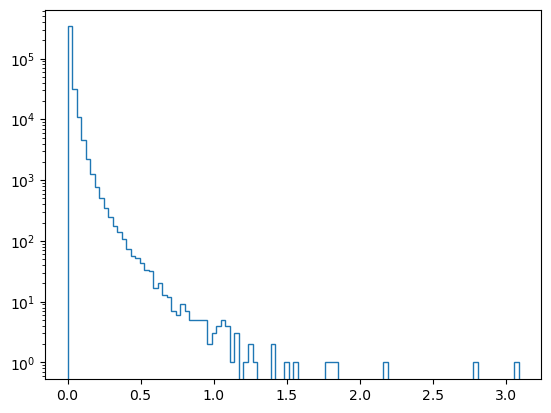

In [58]:
#plot event_weight feature for events with ditau_pt less than 0.4*1e6
e_weigt_cut = combined_bkg[(combined_bkg['ditau_pt'] < 0.4*1e6) & (combined_bkg['event_weight'] < 10)]
plt.hist(e_weigt_cut['event_weight'], bins=100, histtype='step', label='ditau_pt < 0.4*1e6')
plt.yscale('log')
plt.show()

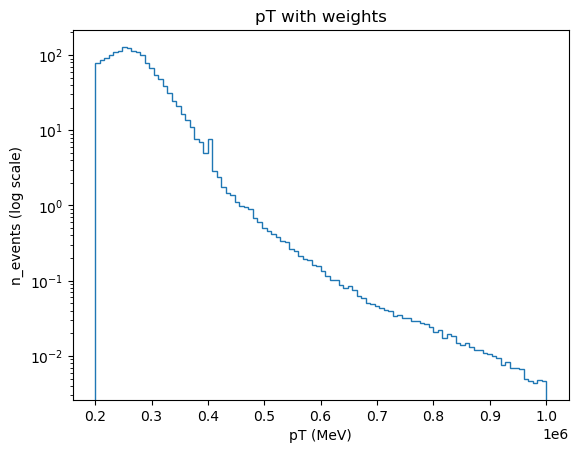

In [7]:
combined_bkg_n = combined_bkg
#filter events with event_weight biogger than 4*1e6
# combined_bkg_n = combined_bkg_n[combined_bkg_n.f_core_subl != -999]

# combined_bkg_n = combined_bkg_n[combined_bkg_n['event_weight'] < 100]

plt.hist(combined_bkg_n['ditau_pt'], bins=100,  weights=combined_bkg_n['event_weight'], histtype='step')
plt.yscale('log')
plt.xlabel('pT (MeV)')
plt.ylabel('n_events (log scale)')
plt.title('pT with weights')
plt.show()


In [20]:
path = "/global/u2/a/agarabag/pscratch/ditdau_samples/"
combined_bkg = pd.read_csv(path+'inc_bdt_bkg.csv')
combined_signal = pd.read_csv(path+'inc_bdt_signal.csv')

In [3]:
path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"
combined_bkg = pd.read_csv(path+'combined_jz_ntuple_inc_omni.csv')
combined_signal = pd.read_csv(path+'vhtautau_ntuple_inc_omni.csv')

In [15]:
signal_scores = combined_signal['bdt_score']
print(np.sum(signal_scores > 0.72) / len(signal_scores))

bkg = combined_bkg['bdt_score']
print(np.sum(bkg > 0.55) / len(bkg))

0.7399353808782297


In [51]:
bkg_bdt = combined_bkg['bdt_score_new'][combined_bkg['bdt_score_new'] > 0]
# print(np.sum(bkg_bdt > 0.045) / len(bkg_bdt))
print(np.sum(bkg_bdt > 0.045) / len(bkg_bdt))

sig_bdt = combined_signal['bdt_score_new'][combined_signal['bdt_score_new'] > 0]
# print(np.sum(sig_bdt > 0.045) / len(sig_bdt))
print(np.sum(sig_bdt > 0.957) / len(sig_bdt))

0.30280855472248075
0.7333744039345224


In [56]:
bkg_omni = combined_bkg['omni_probs'][combined_bkg['omni_probs'] > 0]
# print(np.sum(bkg_omni > 0.015) / len(bkg_omni))
print(np.sum(bkg_omni > 0.013) / len(bkg_omni))

sig_omni = combined_signal['omni_probs'][combined_signal['omni_probs'] > 0]
# print(np.sum(sig_omni > 0.015) / len(sig_omni))
print(np.sum(sig_omni > 0.99951) / len(sig_omni))

0.3105520535196924
0.7365197102768344


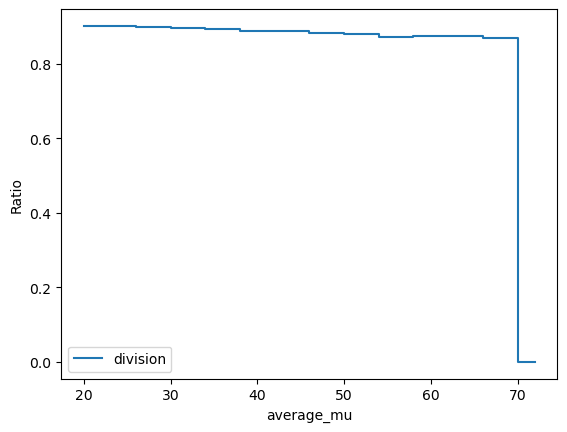

In [30]:

bins = np.linspace(18, 74, 15)
hist1, _ = np.histogram(combined_signal['average_mu'][combined_signal['bdt_score_new'] > 0.8], bins=bins)
hist2, _ = np.histogram(combined_signal['average_mu'][combined_signal['bdt_score_new'] > 0], bins=bins)

# Avoid division by zero by replacing zeros in hist2 with a very small number
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# Calculate the division of the two histograms
hist_division = hist1 / hist2

# Plot the resulting histogram
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.step(bin_centers, hist_division, where='mid', label='division')
plt.xlabel('average_mu')
plt.ylabel('Ratio')
plt.legend()
plt.show()


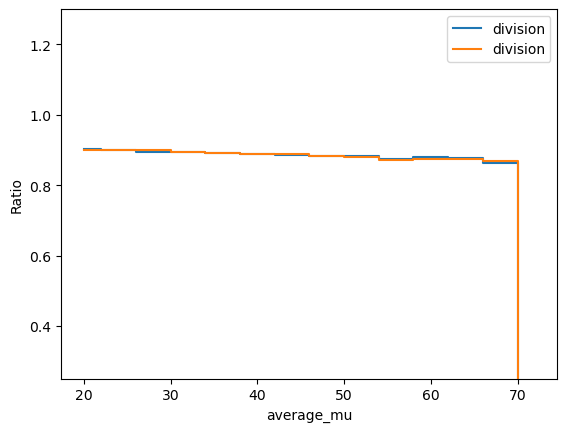

In [31]:

bins = np.linspace(18, 74, 15)
hist3, _ = np.histogram(combined_signal['average_mu'][combined_signal['omni_probs'] > 0.9961], bins=bins)
hist4, _ = np.histogram(combined_signal['average_mu'][combined_signal['omni_probs'] > 0], bins=bins)

# Avoid division by zero by replacing zeros in hist2 with a very small number
hist4 = np.where(hist4 == 0, 1e-10, hist4)

# Calculate the division of the two histograms
hist_division_omni = hist3 / hist4

# Plot the resulting histogram
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.step(bin_centers, hist_division_omni, where='mid', label='division')
plt.step(bin_centers, hist_division, where='mid', label='division')

# plt.step(bin_centers, hist3, where='mid', label='division')
#make teh y axis range from 0.3 to 1.5
plt.ylim(0.25, 1.3)
plt.xlabel('average_mu')
plt.ylabel('Ratio')
plt.legend()
plt.show()


In [33]:
print(hist1)
print(hist3)


[  8889  34988  87662 113606 118301 115475  92634  90647  98013  75002
  16467   4766   3469      0]
[  8891  34945  87352 113414 118260 115370  92598  90777  98346  75264
  16557   4785   3446      0]


In [6]:
len(combined_bkg), len(combined_signal)

(227804, 969063)

In [23]:
import pandas as pd

class DataFrameCuts:
    def __init__(self, df_bkg, df_signal):
        self.df_bkg = df_bkg
        self.df_signal = df_signal

    def apply_cut(self, df, cut_condition):
        return df[cut_condition]

    def cut4(self, df):
        return self.apply_cut(df, ((df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 3)) | ((df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 1)))

    def cut5(self, df):
        return self.apply_cut(df, (df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 1))

    def cut6(self, df):
        return self.apply_cut(df, (df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 3))

    def cut7(self, df):
        return self.apply_cut(df, ((df['n_tracks_lead'] == 1) | (df['n_tracks_lead'] == 3)) & ((df['n_tracks_subl'] == 1) | (df['n_tracks_subl'] == 3)))

    def process(self):
        self.combined_bkg_1p3p = self.cut4(self.df_bkg)
        self.combined_bkg_1p1p = self.cut5(self.df_bkg)
        self.combined_bkg_3p3p = self.cut6(self.df_bkg)

        self.combined_signal_1p3p = self.cut4(self.df_signal)
        self.combined_signal_1p1p = self.cut5(self.df_signal)
        self.combined_signal_3p3p = self.cut6(self.df_signal)


        return {
            'bkg': {
                '1p3p': self.combined_bkg_1p3p,
                '1p1p': self.combined_bkg_1p1p,
                '3p3p': self.combined_bkg_3p3p,
                'inc': self.df_bkg
            },
            'signal': {
                '1p3p': self.combined_signal_1p3p,
                '1p1p': self.combined_signal_1p1p,
                '3p3p': self.combined_signal_3p3p,
                'inc': self.df_signal
            }
        }

In [24]:
combined_bkg = pd.read_csv(path+'inc_bdt_bkg.csv')
combined_signal = pd.read_csv(path+'inc_bdt_vhtautau.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.72]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

# Accessing the results
combined_bkg_1p3p = combined['bkg']['1p3p']
combined_bkg_1p1p = combined['bkg']['1p1p']
combined_bkg_3p3p = combined['bkg']['3p3p']
combined_bkg_inc = combined['bkg']['inc']
combined_signal_1p3p = combined['bkg']['1p3p']
combined_signal_1p1p = combined['bkg']['1p1p']
combined_signal_3p3p = combined['bkg']['3p3p']
combined_signal_inc = combined['bkg']['inc']

combined_bkg_1p3p_bdt = combined_bdt['bkg']['1p3p']
combined_bkg_1p1p_bdt = combined_bdt['bkg']['1p1p']
combined_bkg_3p3p_bdt = combined_bdt['bkg']['3p3p']
combined_bkg_inc_bdt = combined_bdt['bkg']['inc']
combined_signal_1p3p_bdt = combined_bdt['bkg']['1p3p']
combined_signal_1p1p_bdt = combined_bdt['bkg']['1p1p']
combined_signal_3p3p_bdt = combined_bdt['bkg']['3p3p']
combined_signal_inc_bdt = combined_bdt['bkg']['inc']



In [27]:
combined

{'bkg': {'1p3p':          event_id   ditau_pt  IsTruthHadronic  f_core_lead  f_core_subl  \
  0        36079784  289045.94                0     0.894528     0.246616   
  3        35893734  248336.08                0     0.680812     0.653458   
  6        26917460  221883.73                0     0.882286     0.677054   
  9        32924154  208441.89                0     0.842463     0.460940   
  11       30846038  204277.62                0     0.904852     0.615187   
  ...           ...        ...              ...          ...          ...   
  2180550   1082150  252817.34                0     0.726470     0.277918   
  2180555   1284683  253029.23                0     0.669082     0.294558   
  2180557   1489518  298590.72                0     0.768915     0.246262   
  2180559   1110524  325928.28                0     0.757148     0.080900   
  2180561   1033696  290693.70                0     0.959796     0.055276   
  
           f_subjet_subl  f_subjets  f_isotracks  R_max_le

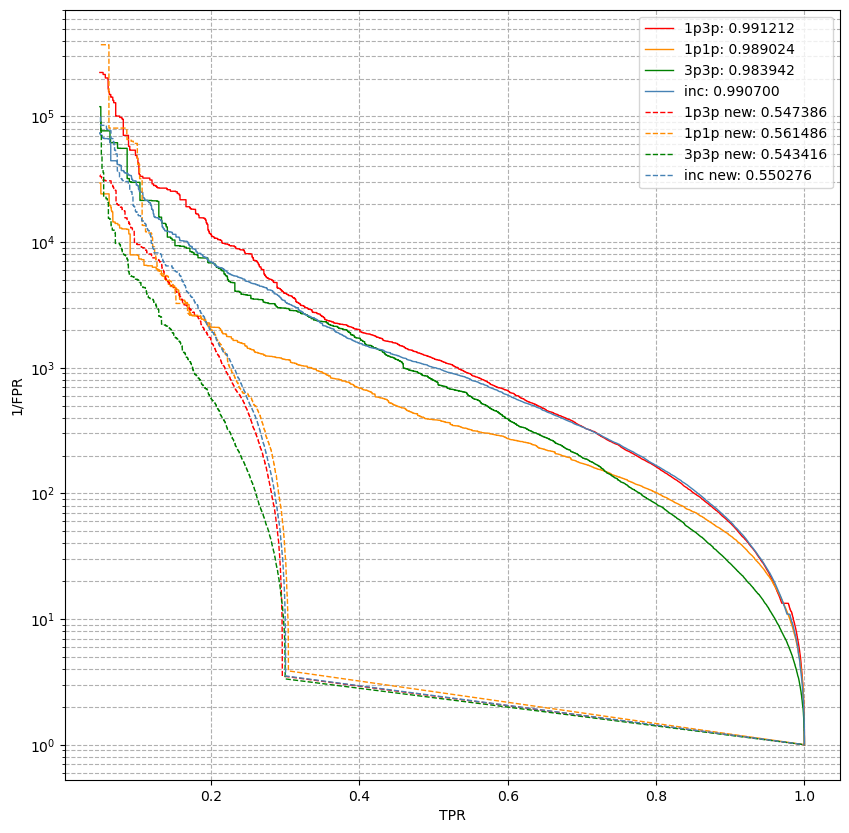

In [26]:
channel = ['1p3p', '1p1p', '3p3p', 'inc']
color = ['red', 'darkorange', 'green', 'steelblue']

fig7 = plt.figure(figsize=(10, 10))
for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score'], combined['bkg'][channel[i]]['bdt_score'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f'{channel[i]}: {roc_auc:.6f}')

for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['inc_new_bdt'], combined['bkg'][channel[i]]['inc_new_bdt'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], linestyle='dashed', label=f'{channel[i]} new: {roc_auc:.6f}')
             
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [8]:
''' Testing for Testing Data
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

def tmp(df):
    df['eventID_mod'] = df['event_id'] % 10
    train_df = df[df['eventID_mod'] < 7] # 70%
    test_df = df[df['eventID_mod'] >= 7] # 30%
    return test_df

combined_signal = tmp(combined_signal)
combined_bkg = tmp(combined_bkg)

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

channel = ['1p3p', '1p1p', '3p3p', 'inc']
color = ['red', 'darkorange', 'green', 'steelblue']

fig7 = plt.figure(figsize=(10, 10))
for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score'], combined['bkg'][channel[i]]['bdt_score'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f'{channel[i]}: {roc_auc:.6f}')

for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score_new'], combined['bkg'][channel[i]]['bdt_score_new'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], linestyle='dashed', label=f'{channel[i]} new: {roc_auc:.6f}')
             
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
'''

' Testing for Testing Data\ncombined_bkg = pd.read_csv(path+\'combined_bkg_inc.csv\')\ncombined_signal = pd.read_csv(path+\'combined_signal_inc.csv\')\n\ndef tmp(df):\n    df[\'eventID_mod\'] = df[\'event_id\'] % 10\n    train_df = df[df[\'eventID_mod\'] < 7] # 70%\n    test_df = df[df[\'eventID_mod\'] >= 7] # 30%\n    return test_df\n\ncombined_signal = tmp(combined_signal)\ncombined_bkg = tmp(combined_bkg)\n\ncuts_processor = DataFrameCuts(combined_bkg, combined_signal)\ncombined = cuts_processor.process()\n\nchannel = [\'1p3p\', \'1p1p\', \'3p3p\', \'inc\']\ncolor = [\'red\', \'darkorange\', \'green\', \'steelblue\']\n\nfig7 = plt.figure(figsize=(10, 10))\nfor i in range(4):\n    fpr, tpr = calc_roc(combined[\'signal\'][channel[i]][\'bdt_score\'], combined[\'bkg\'][channel[i]][\'bdt_score\'], combined[\'signal\'][channel[i]][\'weight\'], combined[\'bkg\'][channel[i]][\'weight\'])\n    roc_auc = auc(fpr, tpr)\n    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f\'{channel[i]

In [49]:
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.96]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

%jsroot on
ROOT.gStyle.SetOptStat(0)
ROOT.gROOT.SetBatch(True)
canvas = ROOT.TCanvas("canvas", "eff_plots", 800, 500)
# canvas.cd()
# canvas.Print("eff_plots.pdf[")

class DataList:
    def __init__(self, combined, combined_bdt):
        self.combined = combined
        self.combined_bdt = combined_bdt
        self.categories = ['1p3p', '1p1p', '3p3p', 'inc']

    def create_list(self, sig_bkg, variable):
        data_list = []
        for category in self.categories:
            data_list.append(self.combined[sig_bkg][category][variable])
            data_list.append(self.combined_bdt[sig_bkg][category][variable])
        return data_list
    
data_list = DataList(combined, combined_bdt)

sig_pt_list = data_list.create_list('signal', 'ditau_pt')
sig_eta_list = data_list.create_list('signal', 'eta')
sig_mu_list = data_list.create_list('signal', 'average_mu')
sig_w_list = data_list.create_list('signal', 'event_weight')
bkg_pt_list = data_list.create_list('bkg', 'ditau_pt')
bkg_eta_list = data_list.create_list('bkg', 'eta')
bkg_mu_list = data_list.create_list('bkg', 'average_mu')
bkg_w_list = data_list.create_list('bkg', 'event_weight')

pt_1p3p_eff_w, pt_1p1p_eff_w, pt_3p3p_eff_w, pt_inc_eff_w = plot_eff(bkg_pt_list, bkg_w_list, "DiJet pT", 20, 200000, 1000000, eta=False)
pt_1p3p_eff_w.SetMarkerStyle(22)
pt_1p1p_eff_w.SetMarkerStyle(22)
pt_3p3p_eff_w.SetMarkerStyle(22)
pt_inc_eff_w.SetMarkerStyle(22)
pt_1p3p_eff_w.Draw(" e")
pt_1p1p_eff_w.Draw("same e")
pt_3p3p_eff_w.Draw("same e")
pt_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(pt_1p3p_eff_w, "1p3p w")
legend.AddEntry(pt_1p1p_eff_w, "1p1p w")
legend.AddEntry(pt_3p3p_eff_w, "3p3p w")
legend.AddEntry(pt_inc_eff_w, "inclusive w")
legend.Draw()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [50]:
eta_1p3p_eff_w, eta_1p1p_eff_w, eta_3p3p_eff_w, eta_inc_eff_w = plot_eff(bkg_eta_list, bkg_w_list, "DiJet eta", 40, -2.5, 2.5, eta=True)
eta_1p3p_eff_w.SetMarkerStyle(22)
eta_1p1p_eff_w.SetMarkerStyle(22)
eta_3p3p_eff_w.SetMarkerStyle(22)
eta_inc_eff_w.SetMarkerStyle(22)
eta_1p3p_eff_w.Draw(" e")
eta_1p1p_eff_w.Draw("same e")
eta_3p3p_eff_w.Draw("same e")
eta_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(eta_1p3p_eff_w, "1p3p")
legend.AddEntry(eta_1p1p_eff_w, "1p1p")
legend.AddEntry(eta_3p3p_eff_w, "3p3p")
legend.AddEntry(eta_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [51]:
eta_inc_eff_w.SetMarkerStyle(22)
eta_inc_eff_w.SetLineColor(ROOT.kBlue)
eta_inc_eff_w.Draw(" e")
legend = ROOT.TLegend(0.7, 0.8, 0.85, 0.9)
legend.AddEntry(eta_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

In [52]:
mu_1p3p_eff_w, mu_1p1p_eff_w, mu_3p3p_eff_w, mu_inc_eff_w = plot_eff(bkg_mu_list, bkg_w_list, "DiJet mu", 20, 18, 74, eta=False)
mu_1p3p_eff_w.SetMarkerStyle(22)
mu_1p1p_eff_w.SetMarkerStyle(22)
mu_3p3p_eff_w.SetMarkerStyle(22)
mu_inc_eff_w.SetMarkerStyle(22)
mu_1p3p_eff_w.Draw(" e")
mu_1p1p_eff_w.Draw("same e")
mu_3p3p_eff_w.Draw("same e")
mu_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(mu_1p3p_eff_w, "1p3p")
legend.AddEntry(mu_1p1p_eff_w, "1p1p")
legend.AddEntry(mu_3p3p_eff_w, "3p3p")
legend.AddEntry(mu_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [53]:
mu_inc_eff_w.SetMarkerStyle(22)
mu_inc_eff_w.SetLineColor(ROOT.kBlue)
mu_inc_eff_w.Draw(" e")
legend = ROOT.TLegend(0.7, 0.7, 0.85, 0.85)
legend.AddEntry(mu_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()


In [54]:
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.96]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

class DataList:
    def __init__(self, combined, combined_bdt):
        self.combined = combined
        self.combined_bdt = combined_bdt
        self.categories = ['1p3p', '1p1p', '3p3p', 'inc']

    def create_list(self, sig_bkg, variable):
        data_list = []
        for category in self.categories:
            data_list.append(self.combined[sig_bkg][category][variable])
            data_list.append(self.combined_bdt[sig_bkg][category][variable])
        return data_list
    
data_list = DataList(combined, combined_bdt)

sig_pt_list = data_list.create_list('signal', 'ditau_pt')
sig_eta_list = data_list.create_list('signal', 'eta')
sig_mu_list = data_list.create_list('signal', 'average_mu')
sig_w_list = data_list.create_list('signal', 'event_weight')
bkg_pt_list = data_list.create_list('bkg', 'ditau_pt')
bkg_eta_list = data_list.create_list('bkg', 'eta')
bkg_mu_list = data_list.create_list('bkg', 'average_mu')
bkg_w_list = data_list.create_list('bkg', 'event_weight')

In [55]:
pt_sig_1p3p_eff_w, pt_sig_1p1p_eff_w, pt_sig_3p3p_eff_w, pt_sig_inc_eff_w = plot_eff(sig_pt_list, sig_w_list, "Signal pT", 20, 200000, 1000000, eta=False)
pt_sig_1p3p_eff_w.SetMarkerStyle(22)
pt_sig_1p1p_eff_w.SetMarkerStyle(22)
pt_sig_3p3p_eff_w.SetMarkerStyle(22)
pt_sig_inc_eff_w.SetMarkerStyle(22)
pt_sig_1p3p_eff_w.Draw(" e")
pt_sig_1p1p_eff_w.Draw("same e")
pt_sig_3p3p_eff_w.Draw("same e")
pt_sig_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(pt_sig_1p3p_eff_w, "1p3p w")
legend.AddEntry(pt_sig_1p1p_eff_w, "1p1p w")
legend.AddEntry(pt_sig_3p3p_eff_w, "3p3p w")
legend.AddEntry(pt_sig_inc_eff_w, "inclusive w")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [12]:
#load a hf file and look whats in die of it 
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#load h5 file 
# path = "/global/homes/a/agarabag/pscratch/OmniLearn/qg/QG/"
# filename = "train_qg.h5"

path =  '/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/'
filename = 'train_tau.h5'
hf = h5py.File
hf = h5py.File(path+filename, 'r')
hf.keys()

#look at the keys
for key in hf.keys():
    print(key)

#printes keys are data, jet, pid
#print content of data key
print(hf['data'])
print(hf['jet'])
print(hf['pid'])

#print actaul values of data key
print(hf['pid'][:])



data
jet
pid
weights
<HDF5 dataset "data": shape (4343244, 10, 11), type "<f8">
<HDF5 dataset "jet": shape (4343244, 16), type "<f8">
<HDF5 dataset "pid": shape (4343244,), type "<i8">
[1 1 1 ... 1 1 1]


In [14]:
print(hf['weights'][:])

[4.80240504e-06 4.14203879e-06 0.00000000e+00 ... 4.59831426e-06
 3.99726587e-06 6.76242257e-06]


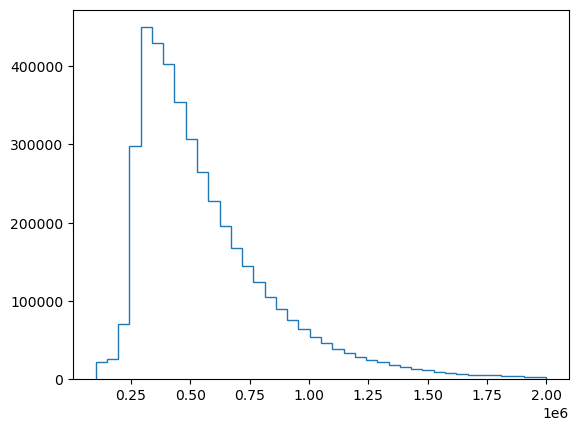

In [10]:
#ket forst variable fo jet
pt = hf['jet'][:, 0]
# pt_bins = np.linspace(200000, 1000000, 41)
# pt_flattening_weights = flattened_pt(pt, pt_bins)
# w = hf['weights'][:]
# plot pt with weoghts w 
binz = np.linspace(100000, 2000000, 41)
plt.hist(pt, bins=binz, histtype='step', )
plt.show()


In [14]:
print(hf['data'][0])


[[ 3.86930109e-01 -8.97137871e-03 -5.36898737e-04 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.25582595e-01 -2.00129615e-01 -3.19737129e-04 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.24110776e-02 -2.46504954e-01 -2.29666070e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#load h5 file 
path = "/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/"
filename = "train_tau.h5"

# path = "/global/homes/a/agarabag/pscratch/OmniLearn/top/"
# filename = "train_atlas.h5"

hf = h5py.File
hf = h5py.File(path+filename, 'r')
print(hf.keys())
print(hf['data'])
print(hf['jet'])
print(hf['pid'])
print(hf['weights'])

# filename2 = "test_tau.h5"
# hf2 = h5py.File
# hf2 = h5py.File(path+filename2, 'r')
# print(hf2['data'])
# print(hf2['jet'])
# print(hf2['pid'])
# hf2.keys()

# filename2 = "val_tau.h5"
# hf3 = h5py.File
# hf3 = h5py.File(path+filename2, 'r')
# print(hf3['data'])
# print(hf3['jet'])
# print(hf3['pid'])
# hf3.keys()

<KeysViewHDF5 ['data', 'jet', 'pid', 'weights']>
<HDF5 dataset "data": shape (4343244, 10, 11), type "<f8">
<HDF5 dataset "jet": shape (4343244, 16), type "<f8">
<HDF5 dataset "pid": shape (4343244,), type "<i8">
<HDF5 dataset "weights": shape (4343244,), type "<f8">


In [2]:
hf['pid'][:]

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [3]:
print(len(hf['weights'][:]))
print(hf['weights'][:20])
# print(len(hf2['pid'][:]))
# print(hf2['pid'][:])
# print(len(hf3['pid'][:]))
# print(hf3['pid'][:])

#see if there are any negative values in the weights
print(np.any(hf['weights'][:] == 0))

#print max a dn min values of weights
print(np.max(hf['weights'][:]))
print(np.min(hf['weights'][:]))


1987293
[0.8066954  0.8066954  0.45486733 1.5440388  1.         1.
 1.         1.         0.3775039  1.         1.         1.
 0.944324   0.9494049  0.44425622 1.         1.         0.15757382
 0.18730964 0.15757382]
False
4.1055393
0.15447335


In [11]:
hf['data'][45]

# see if there are any nan values in 4th elemnt of data
# np.isnan(hf['data'][:,4]).any()

array([[ 1.11797094e-01, -1.10068202e-01,  1.15998563e+01,
        -2.43649390e-02,  1.84312420e+01,  1.56887219e-01,
         1.00000000e+00,  4.00000000e+00,  8.00000000e+00,
         1.00000000e+00],
       [-1.53980255e-01,  1.04537606e-01,  1.09509746e+01,
        -1.94047354e-02,  1.85557289e+01,  1.86112950e-01,
         1.00000000e+00,  4.00000000e+00,  6.00000000e+00,
        -1.00000000e+00],
       [-1.58486605e-01,  1.07792974e-01,  1.07626473e+01,
         1.17030955e-04,  1.83791885e+01,  1.91669844e-01,
         1.00000000e+00,  4.00000000e+00,  7.00000000e+00,
         1.00000000e+00],
       [-1.49433970e-01,  1.07493997e-01,  1.02270941e+01,
        -2.19782069e-02,  1.83766441e+01,  1.84080066e-01,
         1.00000000e+00,  4.00000000e+00,  8.00000000e+00,
        -1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.

In [16]:
hf['data'][45]

array([[ 5.54277897e-02, -3.03735733e-02,  1.26732824e+01,
        -3.13874185e-02, -5.06513824e-01, -8.68285828e+01,
         6.32043814e-02,  1.00000000e+00,  3.00000000e+00,
         8.00000000e+00, -1.00000000e+00],
       [-2.01059580e-01,  1.44072056e-01,  1.17264110e+01,
        -5.25769591e-03, -1.67443153e-01, -8.68297043e+01,
         2.47349372e-01,  1.00000000e+00,  4.00000000e+00,
         8.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
  

In [5]:
hf['jet'][75]

array([4.48290200e+06, 1.20430410e-01, 1.32730991e-01, 1.32730991e-01,
       3.52503806e-01, 0.00000000e+00, 0.00000000e+00, 6.19640350e-01,
       2.09985629e-01, 2.48967018e-02, 4.98574749e-02, 3.98103334e-03,
       0.00000000e+00, 0.00000000e+00, 1.39570007e+02, 2.00000000e+00])

In [11]:
hf['jet'][:, 1:]

array([[2.27211183e-03, 1.19740544e-02, 1.19740544e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       [5.72301587e-03, 1.22327739e-02, 1.22327739e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       [1.19470377e-02, 4.44603385e-03, 4.44603385e-03, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       ...,
       [3.37294000e-03, 3.00280415e-02, 3.00280415e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       [1.03995735e-02, 2.83775441e-02, 2.83775441e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       [4.94797826e-02, 3.08882054e-02, 3.08882054e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00]])

In [6]:
hf['jet'][:]

array([[1.06744140e+07, 2.27211183e-03, 1.19740544e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       [1.21759270e+07, 5.72301587e-03, 1.22327739e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       [3.55724100e+06, 1.19470377e-02, 4.44603385e-03, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       ...,
       [1.52232540e+07, 3.37294000e-03, 3.00280415e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       [1.70219130e+07, 1.03995735e-02, 2.83775441e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00],
       [1.90679240e+07, 4.94797826e-02, 3.08882054e-02, ...,
        1.39570007e+02, 1.39570007e+02, 2.00000000e+00]])

In [7]:
hf['jet']

<HDF5 dataset "jet": shape (4343244, 16), type "<f8">

In [2]:
#load npy file
path = "/global/u2/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/"
filename = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights_keep_11.npy"
# data = np.load(path+filename, allow_pickle=True)
data = np.load(path+filename,allow_pickle=True).item()

print(data.keys())
#print content of data keys
print(data['pred'])
print(data['y'])


dict_keys(['y', 'pred'])
[[2.4321243e-04 9.9975675e-01]
 [4.7619302e-05 9.9995244e-01]
 [6.2865142e-06 9.9999368e-01]
 ...
 [9.9510229e-01 4.8977216e-03]
 [6.0870366e-06 9.9999392e-01]
 [2.2755323e-02 9.7724473e-01]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [3]:
filename_n = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights.npy"
# data = np.load(path+filename, allow_pickle=True)
data_n = np.load(path+filename_n,allow_pickle=True).item()

In [4]:
print(data_n.keys())
# print(data_n['pred'])
# print(data_n['y'])
# print(data_n['event_id'])

dict_keys(['y', 'pred', 'event_id'])


In [6]:
# Assuming the positive class is the second column (index 1)
y_true = data['y'][:, 1]  # Select the true labels for the positive class
y_scores = data['pred'][:, 1]  # Select the predicted probabilities for the positive class
fpr_w, tpr_w, thresholds_w = roc_curve(y_true, y_scores)
tpr_w = tpr_w[fpr_w > 0]
fpr_w = fpr_w[fpr_w > 0]
auc_w = roc_auc_score(y_true, y_scores)

y_true_n = data_n['y'][:, 1]  
y_scores_n = data_n['pred'][:, 1]  
# y_true_n = data_n['y'] 
# y_scores_n = data_n['pred']
fpr_n, tpr_n, thresholds_n = roc_curve(y_true_n, y_scores_n)
#only inlfude fpr values bigger than zero
tpr_n = tpr_n[fpr_n > 0]
fpr_n = fpr_n[fpr_n > 0]
auc_n = roc_auc_score(y_true_n, y_scores_n)

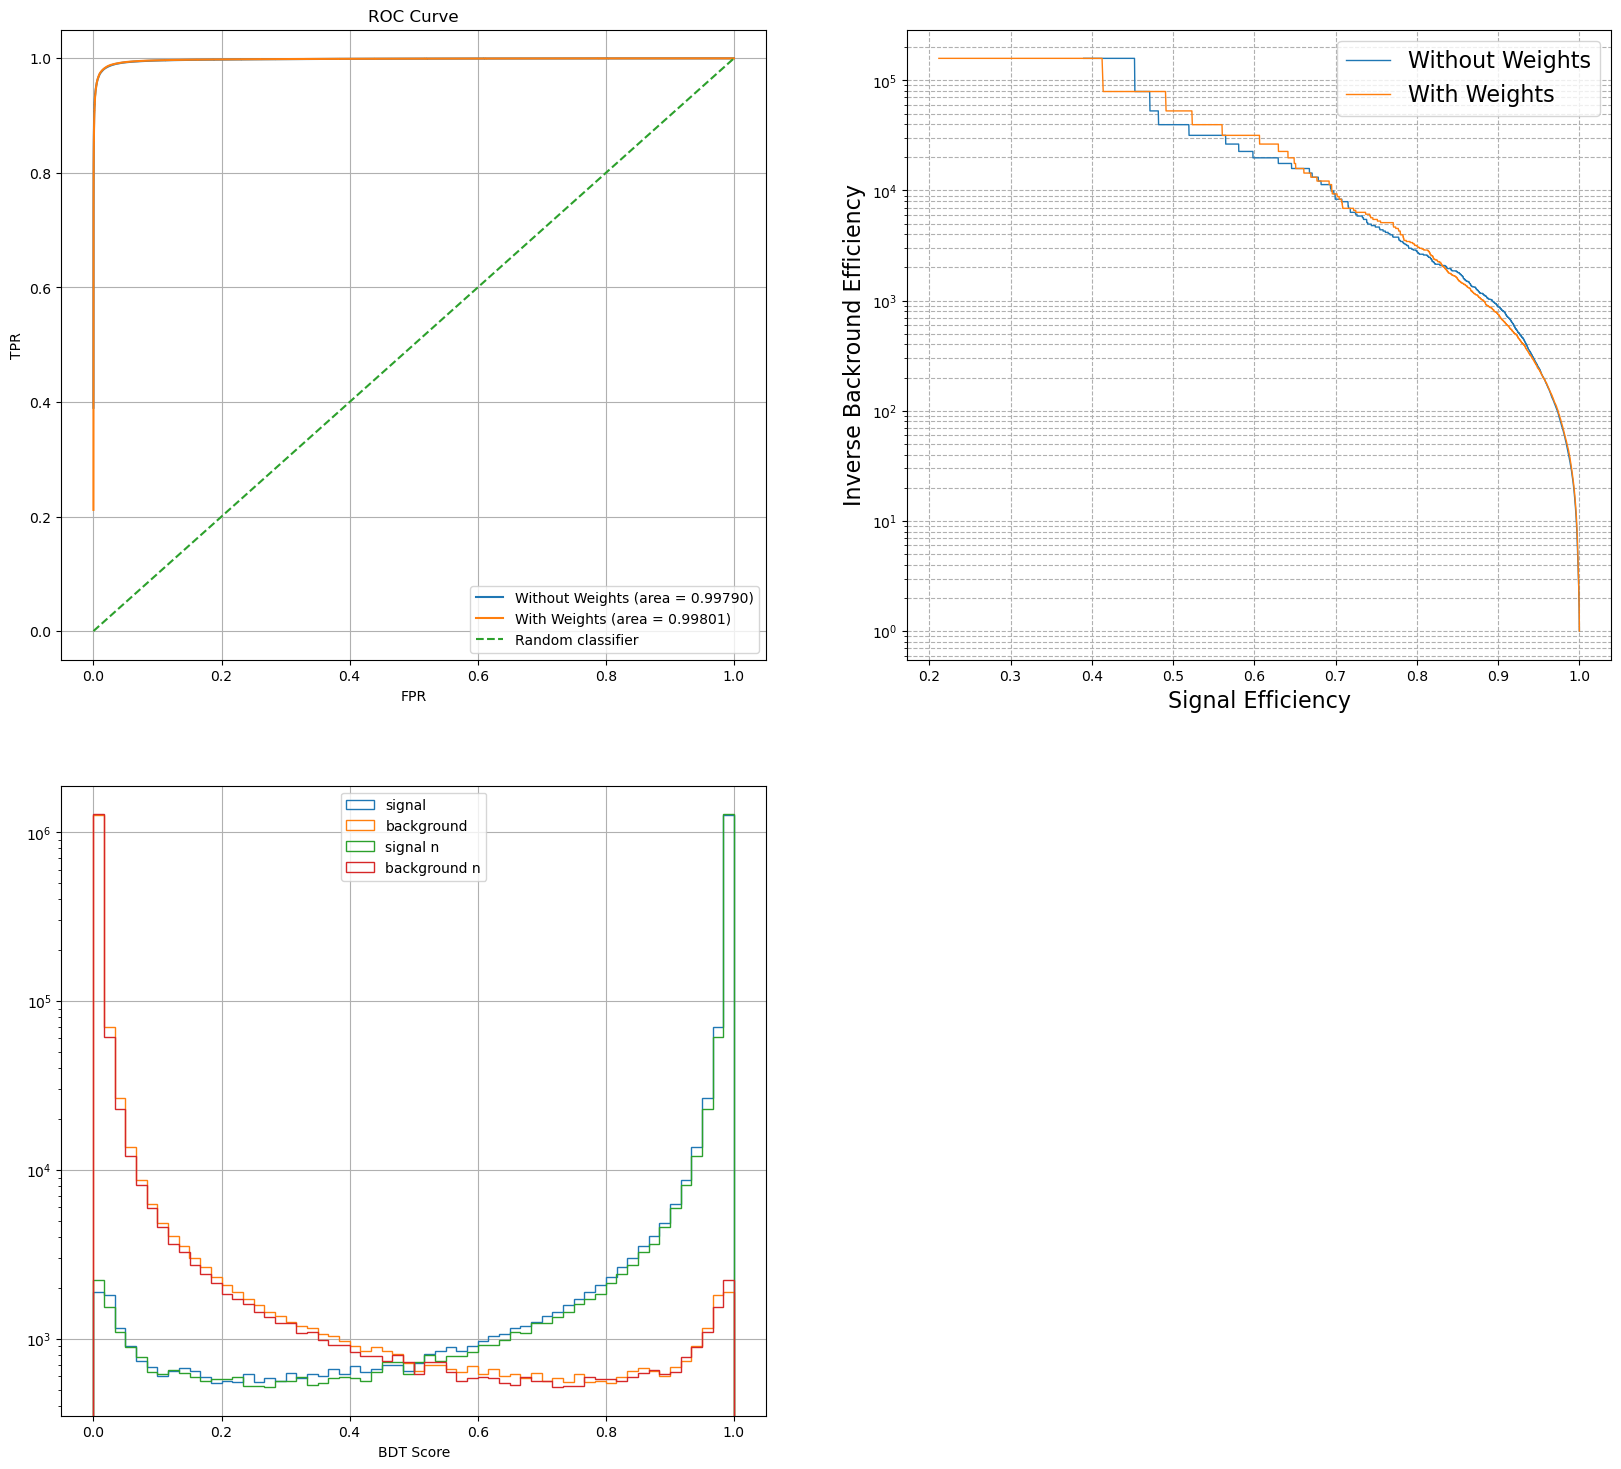

In [7]:
plt.figure(figsize=(20, 18))
plt.subplot(221)
plt.plot(fpr_w, tpr_w, label='Without Weights (area = {:.5f})'.format(auc_w))
plt.plot(fpr_n, tpr_n, label='With Weights (area = {:.5f})'.format(auc_n))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.plot(tpr_w, 1/fpr_w, lw=1, label='Without Weights')
plt.plot(tpr_n, 1/fpr_n, lw=1, label='With Weights')
plt.xlabel('Signal Efficiency', fontsize=16)
plt.ylabel('Inverse Backround Efficiency', fontsize=16)
plt.yscale('log')
plt.legend(prop={'size': 16})
plt.grid(True, which="both", ls="--")

plt.subplot(223)
plt.hist(data['pred'][data['y']==1], bins=60, label='signal', histtype='step')
plt.hist(data['pred'][data['y']==0], bins=60, label='background', histtype='step')
plt.hist(data_n['pred'][data_n['y']==1], bins=60, label='signal n', histtype='step')
plt.hist(data_n['pred'][data_n['y']==0], bins=60, label='background n', histtype='step')
plt.xlabel('BDT Score')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()